In [1]:
import pandas as pd
import multiprocessing as mp
import glob
import numpy as np
import matplotlib.pyplot as plt

from skimage.io import imread

from skimage.data import shepp_logan_phantom
from skimage.transform import radon, rescale

import pickle
import os

from PIL import Image, ImageEnhance, ImageFilter

from skimage.transform import iradon
from skimage.transform import iradon_sart

import math

### Single-threaded reading of view measurements from csv

In [ ]:
cnt=0
strips=[]
csvs=glob.glob("/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose020/out/*.csv")
max_cnt=len(csvs)
for f in csvs: #Takes lot of time, might not need all of them for experimenting
    cnt+=1
    try:
        #print(f"{cnt}/{max_cnt}")
        arr=np.genfromtxt(f,delimiter=',')
        arr=np.exp(arr)
        arr_norm=np.clip(arr,0,255)
        #print(f"{np.min(arr)}-{np.max(arr)}")
        #arr_norm=(arr-np.min(arr))/(np.max(arr)-np.min(arr))*255
        im=Image.fromarray(arr_norm)
        strips.append(im)
    except:
        print("ERROR!!")
    

ERROR!!
ERROR!!
ERROR!!
ERROR!!
ERROR!!
ERROR!!
ERROR!!
ERROR!!
ERROR!!
ERROR!!


### Multi-threaded reading of view measurements from csv

In [2]:
cnt=0
csv_paths=glob.glob("/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose020/out/*.csv")
max_cnt=len(csv_paths)

In [49]:
#Takes approximately 10-15 minutes
#with mp.Manager() as manager:
max_cnt=2000
strips = mp.Manager().list([None]*max_cnt)
def set_strip(inp):
    (csv_path, idx)=inp
    #try:
    arr=np.genfromtxt(csv_path,delimiter=',')
    arr=np.exp(arr)
    arr_norm=np.clip(arr,0,255)
    #arr_norm=(arr-np.min(arr))/(np.max(arr)-np.min(arr))*255
    im=Image.fromarray(arr_norm)
    strips[idx]=im
    #except:
    #   print(f"ERROR at {idx}")

pool = mp.Pool(mp.cpu_count())
pool.map(set_strip, zip(csv_paths,range(max_cnt)))    

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [50]:
l=list(strips)

In [51]:
l[0].show()

In [52]:
np.unique(np.array(l[0]))

array([  0.97112507,   0.9852105 ,   0.9917343 , ..., 107.522484  ,
       109.87024   , 114.182724  ], dtype=float32)

### Create sinogram from views

In [53]:
ANGLES=720
PROJECTIONS=896
START_PERIOD=0
SMALL_R=518
BIG_R=910

In [54]:
MAX_DISPLACEMENT=math.sqrt(SMALL_R**2-(BIG_R/2)**2)
HALF_VIEW_ANGLE=math.asin(MAX_DISPLACEMENT/SMALL_R)
VIEW_ANGLE=2*HALF_VIEW_ANGLE
FULL_CIRCLE=2*math.pi
SEMI_CIRCLE=FULL_CIRCLE/2

In [55]:
def create_sinogram_stupid(strips):
    sinogram = Image.new('L', (ANGLES,PROJECTIONS))
    for idx in range(START_PERIOD*ANGLES,(START_PERIOD+1)*ANGLES):
        strip=Image.fromarray(np.expand_dims(np.mean(np.array(strips[idx]),axis=0),axis=1))
        i=idx-START_PERIOD*ANGLES
        sinogram.paste(strip, (i, 0))
    plt.figure()
    plt.imshow(sinogram,cmap=plt.cm.Greys_r)
    return sinogram

In [56]:
def create_sinogram_stupid_full(strips):
    num=len(strips)
    sinogram = Image.new('L', (PROJECTIONS, num))
    for i in range(num):
        strip=Image.fromarray(np.expand_dims(np.mean(np.array(strips[i]),axis=0),axis=1))
        sinogram.paste(strip, (i, 0))
    plt.figure()
    plt.imshow(sinogram,cmap=plt.cm.Greys_r)
    return sinogram

In [57]:
def create_sinogram_intuitive(strips):
    sinogram=Image.new('L',(ANGLES,PROJECTIONS))
    pixels=sinogram.load()
    for idx in range(START_PERIOD*ANGLES,(START_PERIOD+1)*ANGLES):
        strip=np.mean(np.array(strips[idx]),axis=0)
        i=idx-START_PERIOD*ANGLES
        for j in range(PROJECTIONS):
            pixels[(i+j)%ANGLES,j]=int(strip[j])
    plt.figure()
    plt.imshow(sinogram,cmap=plt.cm.Greys_r)
    return sinogram

In [58]:
def create_sinogram_intuitive_param(strips,slope):
    sinogram=Image.new('L',(ANGLES,PROJECTIONS))
    pixels=sinogram.load()
    for idx in range(START_PERIOD*ANGLES,(START_PERIOD+1)*ANGLES):
        strip=np.mean(np.array(strips[idx]),axis=0)
        i=idx-START_PERIOD*ANGLES
        for j in range(PROJECTIONS):
            pixels[(int(i+slope*j))%ANGLES,j]=int(strip[j])
    plt.figure()
    plt.imshow(sinogram,cmap=plt.cm.Greys_r)
    return sinogram

In [59]:
def create_sinogram_trigonometry(strips):
    
    sinogram=Image.new('L',(ANGLES,PROJECTIONS),color=128)
    pixels=sinogram.load()
    central_angles=np.linspace(0,FULL_CIRCLE,ANGLES)
    displacement_angles=np.linspace(0,HALF_VIEW_ANGLE,PROJECTIONS//2,endpoint=False)
    displacements=np.sin(displacement_angles)*SMALL_R
    
    
    for idx in range(START_PERIOD*ANGLES,(START_PERIOD+1)*ANGLES):
        
        strip=np.min(np.array(strips[idx]),axis=0)
        i=idx-START_PERIOD*ANGLES
        
        for j in range(PROJECTIONS//2):
            angle_rad=(central_angles[i]+displacement_angles[j])%(FULL_CIRCLE)
            angle_pixel=math.floor(ANGLES*angle_rad/(FULL_CIRCLE))
            projection_pixel=math.floor(PROJECTIONS//2+(PROJECTIONS//2)*(displacements[j]/MAX_DISPLACEMENT))
            pixels[angle_pixel,projection_pixel]=int(strip[PROJECTIONS//2+j])
        
        for j in range(PROJECTIONS//2):
            angle_rad=(central_angles[i]-displacement_angles[j]+FULL_CIRCLE)%(FULL_CIRCLE)
            angle_pixel=math.floor(ANGLES*angle_rad/(FULL_CIRCLE))
            projection_pixel=math.floor(PROJECTIONS//2-(PROJECTIONS//2)*(displacements[j]/MAX_DISPLACEMENT))
            pixels[angle_pixel,projection_pixel]=int(strip[PROJECTIONS//2-j])
    
    
    plt.figure()
    plt.imshow(sinogram,cmap=plt.cm.Greys_r)
    return sinogram

In [60]:
def create_sinogram_trigonometry2(strips):
    
    sinogram=Image.new('L',(ANGLES,PROJECTIONS),color=128)
    pixels=sinogram.load()
    central_angles=np.linspace(0,FULL_CIRCLE,ANGLES*2)
    displacement_angles=np.linspace(0,HALF_VIEW_ANGLE,PROJECTIONS//2,endpoint=False)
    displacements=np.sin(displacement_angles)*SMALL_R
    
    
    for idx in range(START_PERIOD*ANGLES*2,(START_PERIOD+1)*ANGLES*2):
        
        strip=np.mean(np.array(strips[idx]),axis=0)
        i=idx-START_PERIOD*ANGLES
        
        for j in range(PROJECTIONS//2):
            angle_rad=(central_angles[i]+displacement_angles[j])%(SEMI_CIRCLE)
            angle_pixel=math.floor(ANGLES*angle_rad/(SEMI_CIRCLE))
            projection_pixel=math.floor(PROJECTIONS//2+(PROJECTIONS//2)*(displacements[j]/MAX_DISPLACEMENT))
            pixels[angle_pixel,projection_pixel]+=int(strip[PROJECTIONS//2+j]/2)
        
        for j in range(PROJECTIONS//2):
            angle_rad=(central_angles[i]-displacement_angles[j]+SEMI_CIRCLE)%(SEMI_CIRCLE)
            angle_pixel=math.floor(ANGLES*angle_rad/(SEMI_CIRCLE))
            projection_pixel=math.floor(PROJECTIONS//2-(PROJECTIONS//2)*(displacements[j]/MAX_DISPLACEMENT))
            pixels[angle_pixel,projection_pixel]+=int(strip[PROJECTIONS//2-j]/2)
    
    
    plt.figure()
    plt.imshow(sinogram,cmap=plt.cm.Greys_r)
    return sinogram

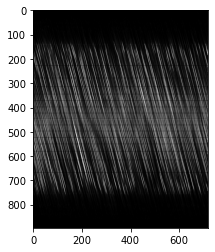

In [63]:
sinogram=create_sinogram_trigonometry2(strips)

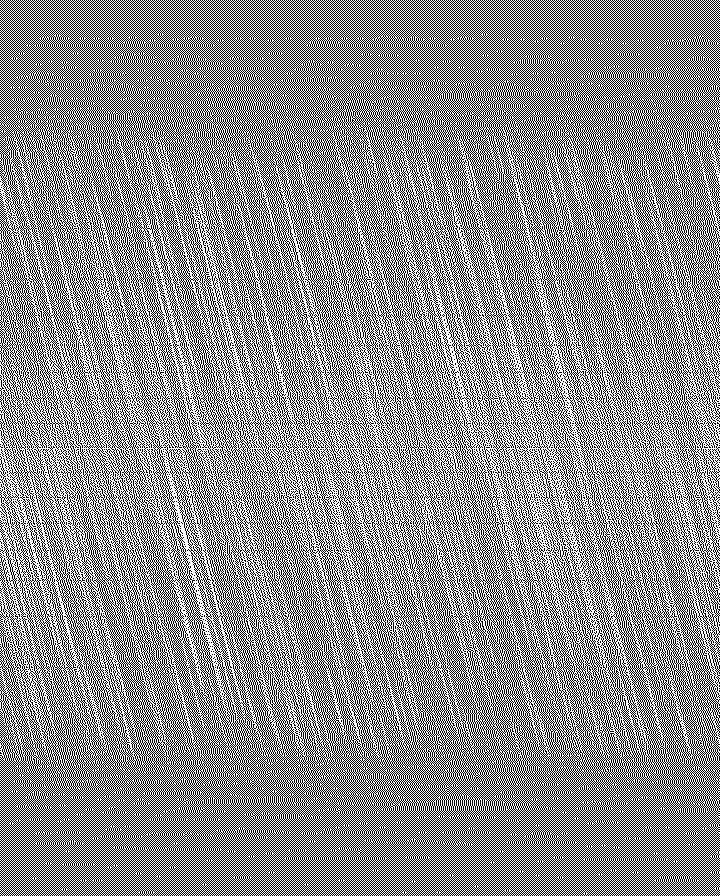

In [62]:
sinogram.convert('1').show()

In [ ]:
sinogram.resize((720, 896), Image.BICUBIC)

In [ ]:
sinogram.resize((45, 56), Image.BICUBIC)

In [ ]:
sinogram.filter(ImageFilter.GaussianBlur(1))

In [ ]:
sinogram.filter(ImageFilter.SMOOTH_MORE)

In [ ]:
for method in [create_sinogram_stupid,create_sinogram_intuitive,create_sinogram_trigonometry]:
    method(strips)
#sinogram_stupid=create_sinogram_stupid(strips)

In [ ]:
#sinogram.save("/mnt/idms/PROJECTS/Lung/sinogram_Domi/spr_dose020/first_sinogram.jpg")

### Inverse Radon

In [21]:
sino_arr=np.array(sinogram)
theta = np.linspace(0., 180., sino_arr.shape[1], endpoint=False)
reconstruction_fbp = iradon(sino_arr, theta=theta, circle=False)#, circle=True)

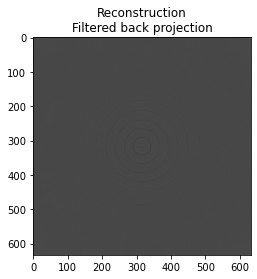

In [22]:
plt.title("Reconstruction\nFiltered back projection")
plt.imshow(reconstruction_fbp, cmap=plt.cm.Greys_r)
plt.show()